In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
#读取数据
file_path = "C:/Users/Administrator/cbg_patterns.csv"
data = pd.read_csv(file_path)

In [51]:
#对数据预处理<删除含有{},[]的无效值>
data = data.drop(index=data[data['visitor_home_cbgs'].isin({})].index)
data = data.drop(index=data[data['visitor_work_cbgs'].isin({})].index)
data = data.drop(index=data[data['related_same_day_brand'].isin([])].index)
data = data.drop(index=data[data['related_same_month_brand'].isin([])].index)
data = data.drop(index=data[data['top_brands'].isin([])].index)
data = data.drop(index=data[data['popularity_by_hour'].isin([])].index)
data = data.drop(index=data[data['popularity_by_day'].isin({})].index)

In [52]:
#频繁模式挖掘
def createC1(dataset):  # 产生单个item的集合
    C1 = []
    for transaction in dataset:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    C1.sort()
    return map(frozenset, C1)  # 给C1.list每个元素执行函数

def scanD(D, ck, minSupport):  # dataset,a list of candidate set,最小支持率 支持度计数
    ssCnt = {}
    # temp_D = list(D)
    numItem = float(len(D))
    # print('numItem:', numItem)
    temp_ck = list(ck)
    for tid in D:
        for can in temp_ck:
            if can.issubset(tid):
                if can not in ssCnt:
                    ssCnt[can] = 1
                else:
                    ssCnt[can] += 1
    retList = []
    supportData = {}
    for key in ssCnt:
        if numItem == 0:
            continue
        support = ssCnt[key] / numItem  # 支持度
        if support >= minSupport:            
            retList.insert(0, key)
            supportData[key] = support
    return retList, supportData  # 返回频繁k项集，相应支持度
def aprioriGen(Lk, k):  # create ck(k项集)
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i + 1, lenLk):
            L1 = list(Lk[i])[:k - 2]
            L2 = list(Lk[j])[:k - 2]
            L1.sort()
            L2.sort()  # 排序
            if L1 == L2:  # 比较i,j前k-1个项若相同，和合并它俩
                retList.append(Lk[i] | Lk[j])  # 加入新的k项集 | stanf for union
    return retList # ck

def apriori(datset, minSupport):
    C1 = createC1(datset)  # map
    D = datset
    L1, supportData = scanD(D, C1, minSupport)  # 利用k项集生成频繁k项集, 即满足最小支持率的k项集
    L = [L1]  # L保存所有频繁项集

    k = 2
    while (len(L[k - 2]) > 0):  # 直到频繁k-1项集为空
        Ck = aprioriGen(L[k - 2], k)  # 利用频繁k-1项集 生成k项集
        Lk, supK = scanD(D, Ck, minSupport)
        supportData.update(supK)  # 保存新的频繁项集与其支持度
        L.append(Lk)  # 保存频繁k项集
        k += 1
    return L, supportData  # 返回所有频繁项集，与其相应的支持率

In [53]:
#关联规则
def calcConf(freqSet, H, supportData, brl, minConf):
    prunedH = []
    lift = []
    file = open("cataset_items.txt","a",encoding = "utf-8")
    for conseq in H:  # 后件中的每个元素
        conf = supportData[freqSet] / supportData[freqSet - conseq]
        if conf >= minConf:
            file.write(str(freqSet - conseq)+"-->"+str(conseq)+" support:"+str(supportData[freqSet])+" conf:"+str(conf)+'\n')
            brl.append((freqSet - conseq, conseq, supportData[freqSet], conf))  # 添加入规则集中
            prunedH.append(conseq)  # 添加入被修剪过的H中
    file.close()
    return prunedH

def rulesFromConseq(freqSet, H, supportData, brl, minConf):
    m = len(H[0])  # H是一系列后件长度相同的规则，所以取H0的长度即可
    if (len(freqSet) > m + 1):
        Hmp1 = aprioriGen(H, m + 1)
        Hmp1 = calcConf(freqSet, Hmp1, supportData, brl, minConf)
        if (len(Hmp1) > 1):
            rulesFromConseq(freqSet, Hmp1, supportData, brl, minConf)

def generateRules(L, supportData, minConf):
    bigRuleList = []  # 存储规则
    for i in range(1, len(L)):
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            if (i > 1):
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf)
            else:
                calcConf(freqSet, H1, supportData, bigRuleList, minConf)
    return bigRuleList

In [54]:
#对规则方法进行评价
def lift_eval(rules, suppData): # lift evaluation
    # lift(A, B) = P(A交B) / (P(A) * P(B)) = P(A) * P(B | A) / (P(A) * P(B)) = P(B | A) / P(B) = confidence(A— > B) / support(B) = confidence(B— > A) / support(A)
    lift = []
    for rule in rules:
        freqSet_conseq = rule[0]
        conseq = rule[1]
        lift_val = float(rule[3]) / float(suppData[rule[1]])
        lift.append([freqSet_conseq, conseq, lift_val])
    return lift
def cos_eval(rules, suppData): # allconf evaluation
    cos = []
    for rule in rules:
        freqSet_conseq = rule[0]
        conseq = rule[1]
        cos_val = (float(rule[3])*float(suppData[rule[0]])) / pow(float(suppData[rule[0]])*float(suppData[rule[1]]), 1/2)
        cos.append([freqSet_conseq, conseq, cos_val])
    return cos

In [55]:
#对related_same_day_brand列进行处理
day = pd.DataFrame(data,columns=['related_same_day_brand'])
day.reset_index(drop=True,inplace=True)
day_list = []
for i in day.related_same_day_brand:
    brand = []
    i = i.strip('[]')
    i = i.split(',')  # to list
    for j in i:
        brand.append(j.strip('""').strip(' '))
    day_list.append(brand)
minSupport = 0.05
day_L, day_suppData = apriori(day_list,minSupport)
for i in range(len(day_L)-1):
    print('频繁', i+1, '项集')
    print(day_L[i])
day_rules = generateRules(day_L, day_suppData, minConf=0.2)
day_lifts = lift_eval(day_rules, day_suppData)
day_cos = cos_eval(day_rules, day_suppData)

频繁 1 项集
[frozenset({"Dunkin' Donuts"}), frozenset({''}), frozenset({'starbucks'}), frozenset({'Dollar General'}), frozenset({'Shell Oil'}), frozenset({'walmart'}), frozenset({'mcdonalds'})]
频繁 2 项集
[frozenset({'walmart', 'mcdonalds'})]


In [56]:
#对related_same_month_brand列进行处理
month = pd.DataFrame(data,columns=['related_same_month_brand'])
month.reset_index(drop=True,inplace=True)
month_list = []
for i in month.related_same_month_brand:
    brand = []
    i = i.strip('[]')
    i = i.split(',')  # to list
    for j in i:
        brand.append(j.strip('""').strip(' '))
    month_list.append(brand)
minSupport = 0.2
month_L, month_suppData = apriori(month_list,minSupport)
for i in range(len(month_L)-1):
    print('频繁', i+1, '项集')
    print(month_L[i])
month_rules = generateRules(month_L, month_suppData, minConf=0.5)
month_lifts = lift_eval(month_rules, month_suppData)
month_cos = cos_eval(month_rules, month_suppData)

频繁 1 项集
[frozenset({'BP'}), frozenset({"Dunkin' Donuts"}), frozenset({'7-Eleven US'}), frozenset({'Target'}), frozenset({'Walgreens'}), frozenset({'starbucks'}), frozenset({'Chevron'}), frozenset({'walmart'}), frozenset({'mcdonalds'}), frozenset({'Shell Oil'}), frozenset({'SUBWAY'}), frozenset({'Dollar General'}), frozenset({'Chick-fil-A'})]
频繁 2 项集
[frozenset({'BP', 'mcdonalds'}), frozenset({'mcdonalds', "Dunkin' Donuts"}), frozenset({'Target', 'mcdonalds'}), frozenset({'mcdonalds', 'Walgreens'}), frozenset({'SUBWAY', 'starbucks'}), frozenset({'mcdonalds', 'starbucks'}), frozenset({'walmart', 'starbucks'}), frozenset({'Chick-fil-A', 'mcdonalds'}), frozenset({'Dollar General', 'mcdonalds'}), frozenset({'SUBWAY', 'mcdonalds'}), frozenset({'Shell Oil', 'mcdonalds'}), frozenset({'Chick-fil-A', 'walmart'}), frozenset({'Dollar General', 'walmart'}), frozenset({'SUBWAY', 'walmart'}), frozenset({'Shell Oil', 'walmart'}), frozenset({'walmart', 'mcdonalds'})]
频繁 3 项集
[frozenset({'walmart', 'mcd

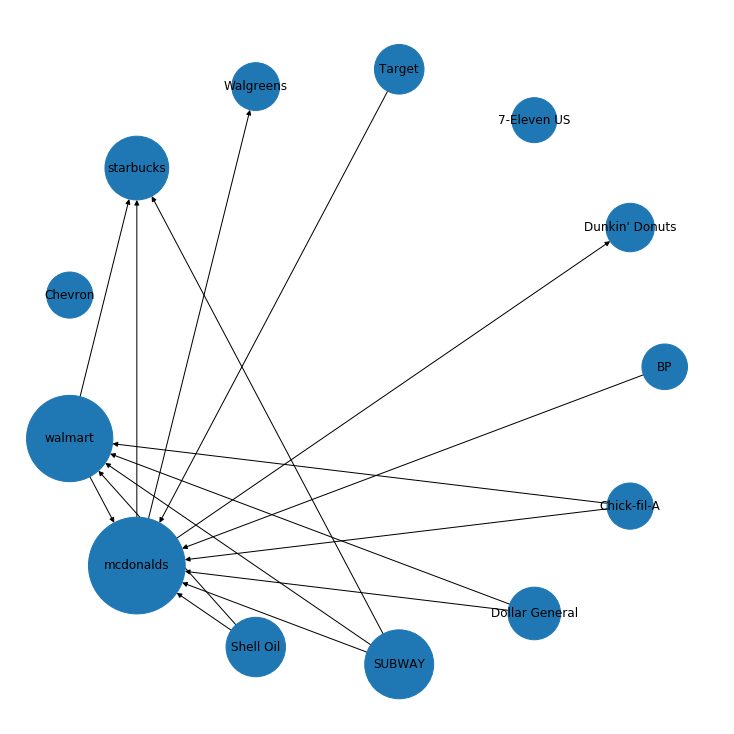

In [58]:
#可视化
import networkx as nx 
plt.figure(figsize=(10,10))
G = nx.DiGraph()  #创建空的网络图
node_size = []
for node in month_L[0]:
    node_size.append(int(month_suppData[node]*10000))
    n = list(set(node))
    G.add_node(n[0])  # 添加点  
for nodes in month_L[1]:
    n = list(set(nodes))
    a, b = n[0], n[1]
    G.add_edge(a, b)
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels = True, node_size=node_size)
plt.show()

In [66]:
#散点图
def points_draw(rules):
    x = []
    y = []
    for rule in rules:
        x.append(rule[2])  # sup
        y.append(rule[3])  # conf
    return x, y
#lift&support
def lift_draw(lifts, rules):
    x = []
    y = []
    for lift in lifts:
        x.append(lift[2])
    for rule in rules:
        y.append(rule[2])  # sup
    return x, y

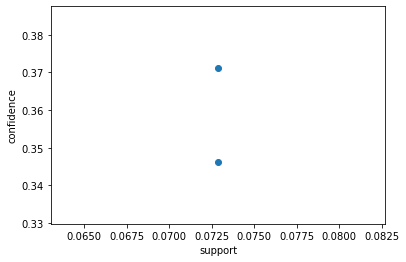

In [63]:
x, y = points_draw(day_rules)
plt.xlabel('support') 
plt.ylabel('confidence') 
plt.scatter(x, y)
plt.show()

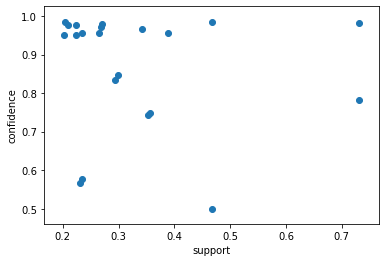

In [64]:
x, y = points_draw(month_rules)
plt.xlabel('support') 
plt.ylabel('confidence')  
plt.scatter(x, y)
plt.show()

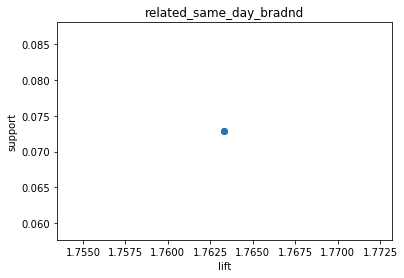

In [67]:
x, y = lift_draw(day_lifts, day_rules)
plt.title('related_same_day_bradnd')
plt.xlabel('lift') 
plt.ylabel('support')  
plt.scatter(x, y)
plt.show()

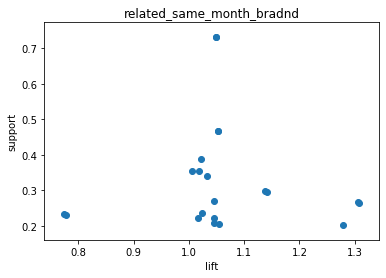

In [68]:

x, y = draw(month_lifts, month_rules)
plt.title('related_same_month_bradnd')
plt.xlabel('lift') 
plt.ylabel('support')  
plt.scatter(x, y)
plt.show()